<a href="https://colab.research.google.com/github/SrutiGoteti/IIIT-AI-ML-labs-and-projects/blob/main/AIML_Module_4_Lab_1_Perceptron_and_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Experiments Lab
**Goals**
- Implement perceptron training with loss/error tracking.
- Run experiments on real datasets (Sonar, Banknote).
- Compare different learning rates and observe convergence.
- Try a non-linearly separable toy dataset and note observations.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)


In [3]:
def perceptron_train(X, y, learning_rate=1.0, epochs=100,
                     add_bias=True, shuffle=True, early_stop=True,
                     X_val=None, y_val=None, verbose=False):

    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int)
    n_samples = X.shape[0]

    # Optionally append bias feature = -1 to be consistent with your earlier code
    if add_bias:
        Xb = np.hstack([X, -np.ones((n_samples, 1))])
    else:
        Xb = X.copy()

    n_features = Xb.shape[1]
    w = np.zeros(n_features)

    errors = []
    losses = []
    accuracies = []
    val_accuracies = []

    converged_epoch = None

    for epoch in range(epochs):
        idx = np.arange(n_samples)
        if shuffle:
            np.random.shuffle(idx)

        error_count = 0
        total_negative_margin = 0.0

        for i in idx:
            xi = Xb[i]
            yi = y[i]
            margin = np.dot(w, xi) * yi
            if margin <= 0:                 # misclassified or on boundary
                w = w + learning_rate * yi * xi
                error_count += 1
                total_negative_margin += margin

        errors.append(error_count)
        losses.append(-total_negative_margin)     # make positive for plotting
        accuracies.append((n_samples - error_count) / n_samples)

        # validation accuracy if provided
        if X_val is not None and y_val is not None:
            preds_val = perceptron_predict(w, X_val, add_bias=add_bias)
            val_accuracies.append(np.mean(preds_val == np.asarray(y_val)))

        if verbose:
            print(f"Epoch {epoch}: errors={error_count}, loss={losses[-1]:.4f}, acc={accuracies[-1]:.4f}")

        if error_count == 0 and converged_epoch is None:
            converged_epoch = epoch
            if early_stop:
                if verbose:
                    print(f"Converged at epoch {epoch}")
                break

    return {
        'weights': w,
        'errors': errors,
        'losses': losses,
        'accuracies': accuracies,
        'val_accuracies': val_accuracies,
        'converged_epoch': converged_epoch
    }

def perceptron_predict(w, X, add_bias=True):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    if add_bias:
        Xb = np.hstack([X, -np.ones((n, 1))])
    else:
        Xb = X
    scores = Xb.dot(w)
    preds = np.sign(scores)
    preds[preds == 0] = -1
    return preds


In [4]:
def plot_errors(result, title='Training errors'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(result['errors'], marker='o')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Misclassified count')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

def plot_losses(result, title='Training loss'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(result['losses'], marker='o')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Total negative-margin (positive plotted)')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

def plot_decision_line_2d(w, X, y, xlim=None, ylim=None, title='Decision boundary'):
    """
    Plot 2D scatter (first 2 features) and decision line from weight vector w
    Assumes w corresponds to features [x0, x1, bias] with bias multiplied by -1 in X.
    """
    if len(w) != 3:
        raise ValueError("w must be length 3 (w0,w1,bias) to use plot_decision_line_2d()")

    # scatter
    fig, ax = plt.subplots(figsize=(6,6))
    neg_idx = np.where(np.asarray(y) == -1)[0]
    pos_idx = np.where(np.asarray(y) == 1)[0]
    ax.scatter(X[neg_idx,0], X[neg_idx,1], marker='_', s=120, label='-1')
    ax.scatter(X[pos_idx,0], X[pos_idx,1], marker='+', s=120, label='+1')

    # decision boundary: w0*x + w1*y + w_bias * (-1) = 0  => y = -(w0*x + w_bias * (-1)) / w1
    w0, w1, w_bias = w[0], w[1], w[2]
    if xlim is None:
        xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    else:
        xmin, xmax = xlim
    xs = np.array([xmin, xmax])
    if np.abs(w1) < 1e-8:
        x_line = - (w_bias * (-1)) / w0
        ax.axvline(x_line, color='blue', label='decision boundary')
    else:
        ys = - (w0 * xs + w_bias * (-1)) / w1
        ax.plot(xs, ys, color='blue', label='decision boundary')

    ax.legend()
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(title)
    ax.grid(True)
    plt.show()


Experiment A — Sonar dataset

shape: (208, 61)
Converged epoch: 260
Final training accuracy: 1.0
Final validation accuracy: 0.7380952380952381


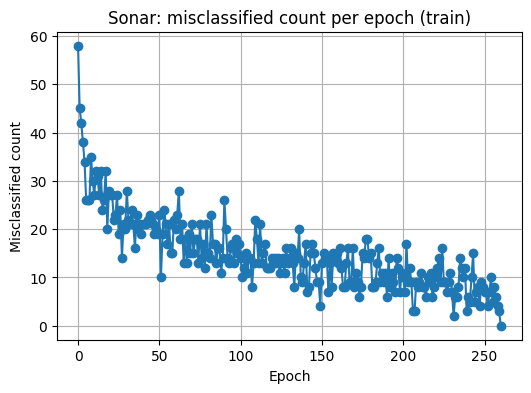

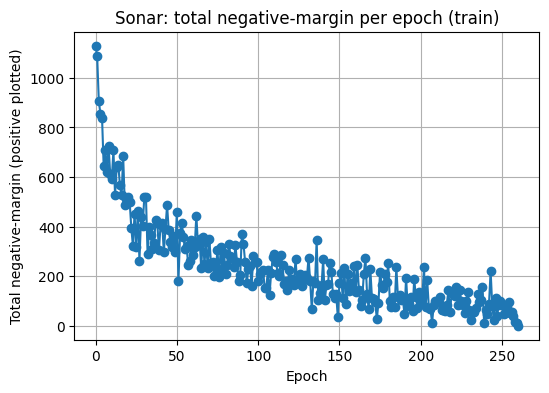

In [5]:
# Download Sonar from UCI (no headers, last column is label 'R' or 'M')
sonar_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
df = pd.read_csv(sonar_url, header=None)
print("shape:", df.shape)
X = df.iloc[:, :-1].values
y_raw = df.iloc[:, -1].values

# Map labels: 'R' -> -1, 'M' -> +1  (you can flip if you prefer)
y = np.where(y_raw == 'R', -1, 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features (important for perceptron speed)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Train the perceptron (learning_rate=1)
res = perceptron_train(X_train_s, y_train, learning_rate=1.0, epochs=1000,
                       add_bias=True, shuffle=True, early_stop=True,
                       X_val=X_test_s, y_val=y_test, verbose=False)

print("Converged epoch:", res['converged_epoch'])
print("Final training accuracy:", res['accuracies'][-1])
if res['val_accuracies']:
    print("Final validation accuracy:", res['val_accuracies'][-1])

plot_errors(res, title='Sonar: misclassified count per epoch (train)')
plot_losses(res, title='Sonar: total negative-margin per epoch (train)')


Experiment B — Banknote dataset

shape: (1372, 5)
Converged epoch: None
Final training accuracy: 0.9881494986326345
Final validation accuracy: 0.9781818181818182


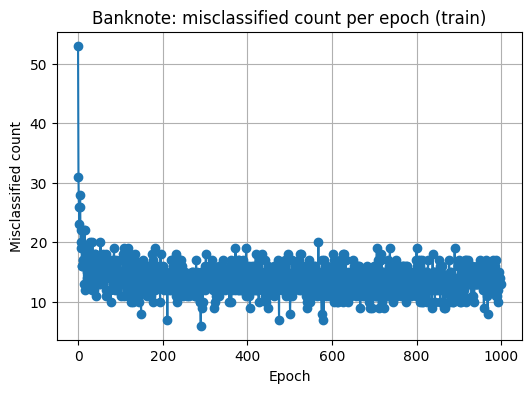

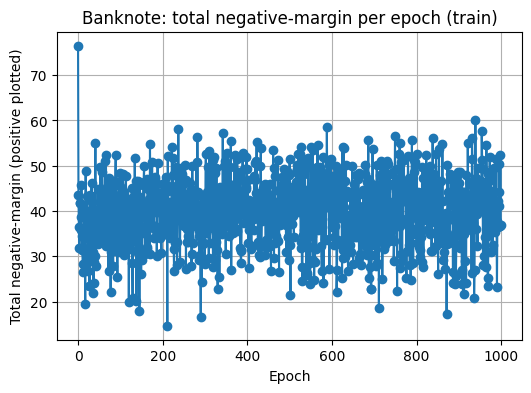

In [6]:
banknote_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
df2 = pd.read_csv(banknote_url, header=None)
print("shape:", df2.shape)
Xb = df2.iloc[:, :-1].values
yb_raw = df2.iloc[:, -1].values    # labels 0 or 1

# Map labels: 0 -> -1, 1 -> +1
yb = np.where(yb_raw == 0, -1, 1)

# split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, stratify=yb, random_state=42)

# scale
scaler_b = StandardScaler()
Xb_train_s = scaler_b.fit_transform(Xb_train)
Xb_test_s = scaler_b.transform(Xb_test)

res_b = perceptron_train(Xb_train_s, yb_train, learning_rate=1.0, epochs=1000,
                        add_bias=True, shuffle=True, early_stop=True,
                        X_val=Xb_test_s, y_val=yb_test, verbose=False)

print("Converged epoch:", res_b['converged_epoch'])
print("Final training accuracy:", res_b['accuracies'][-1])
if res_b['val_accuracies']:
    print("Final validation accuracy:", res_b['val_accuracies'][-1])

plot_errors(res_b, title='Banknote: misclassified count per epoch (train)')
plot_losses(res_b, title='Banknote: total negative-margin per epoch (train)')


Learning rate sweep

lr=0.01: converged_epoch=282, final_errors=0
lr=0.1: converged_epoch=278, final_errors=0
lr=1.0: converged_epoch=306, final_errors=0
lr=5.0: converged_epoch=265, final_errors=0
lr=10.0: converged_epoch=262, final_errors=0


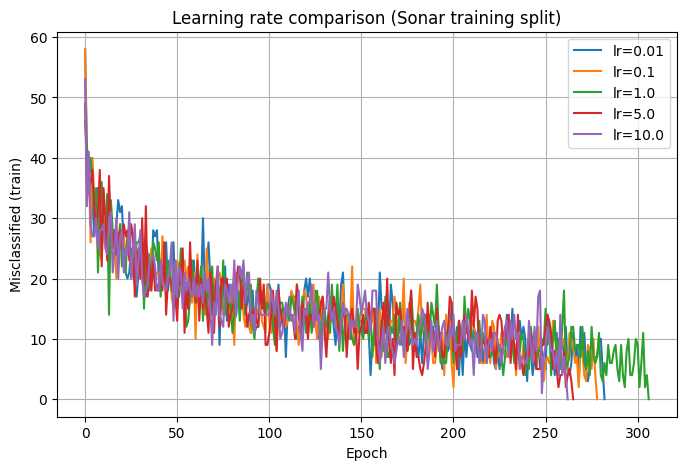

In [7]:
lrs = [0.01, 0.1, 1.0, 5.0, 10.0]
results_lr = {}

for lr in lrs:
    res_lr = perceptron_train(X_train_s, y_train, learning_rate=lr, epochs=500,
                              add_bias=True, shuffle=True, early_stop=True,
                              X_val=None, y_val=None, verbose=False)
    results_lr[lr] = res_lr
    print(f"lr={lr}: converged_epoch={res_lr['converged_epoch']}, final_errors={res_lr['errors'][-1]}")

# Plot misclassification counts for each lr (truncate to same x-axis length for clarity)
plt.figure(figsize=(8,5))
max_epochs = max(len(r['errors']) for r in results_lr.values())
for lr, r in results_lr.items():
    epochs = np.arange(len(r['errors']))
    plt.plot(epochs, r['errors'], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Misclassified (train)")
plt.title("Learning rate comparison (Sonar training split)")
plt.legend()
plt.grid(True)
plt.show()


Non-linearly separable toy dataset

Errors per epoch (first 20): [4, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2]
Converged epoch: 74


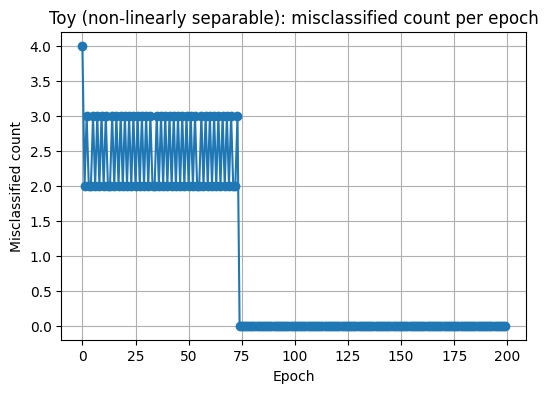

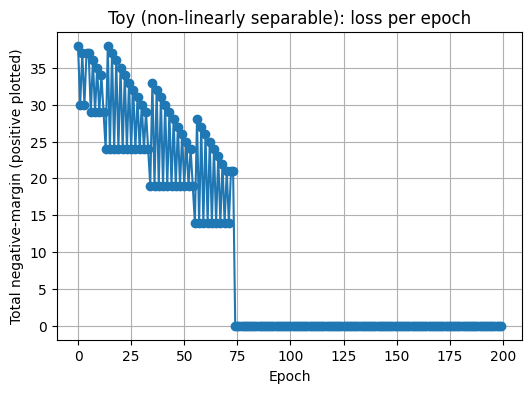

Final predictions: [-1. -1.  1. -1. -1.]
True labels:       [-1 -1  1 -1 -1]


In [8]:
X_toy = np.array([
    [-2, 4, -1],
    [4, 1, -1],
    [1, 6, -1],
    [2, 4, -1],
    [6, 2, -1],
])
y_toy = np.array([-1, -1,  1, -1, -1])

# Remove the bias column from input X
X_toy_no_bias = X_toy[:, :2]

# Train the perceptron for many epochs
res_toy = perceptron_train(X_toy_no_bias, y_toy, learning_rate=1.0, epochs=200,
                           add_bias=True, shuffle=False, early_stop=False, verbose=False)

print("Errors per epoch (first 20):", res_toy['errors'][:20])
print("Converged epoch:", res_toy['converged_epoch'])
plot_errors(res_toy, title='Toy (non-linearly separable): misclassified count per epoch')
plot_losses(res_toy, title='Toy (non-linearly separable): loss per epoch')

# final predictions
w_toy = res_toy['weights']
preds_toy = perceptron_predict(w_toy, X_toy_no_bias, add_bias=True)
print("Final predictions:", preds_toy)
print("True labels:      ", y_toy)


## Observations

- **Real datasets (Sonar, Banknote)**:
  - After standardizing inputs, perceptron often converges quickly when the training set is (nearly) linearly separable.
  - For Sonar, convergence depends on train/test split; you might get complete separation on training, but test accuracy is the meaningful metric.
  - For Banknote, a simple linear boundary often suffices and perceptron converges quickly.

- **Effect of learning rate**:
  - Small LR → small updates, slow convergence (but stable).
  - Moderate LR (~0.1–1) → faster convergence.
  - Very large LR → may overshoot and cause oscillations; can still converge on separable data but often less stable.

- **Non-linearly separable toy dataset**:
  - Perceptron fails to reach zero error.
  - Training errors keep oscillating; the algorithm will not converge to a perfect separator because none exists.
  - In practice, use a maximum epoch (or early stopping based on a separate validation metric) to avoid infinite runs.




# Perceptron Learning on 2-bit Boolean Functions

## Dataset: AND function
We have a dataset where:
- \( x = (x_1, x_2) \in \{0,1\} \times \{0,1\} \)
- \( y \in \{-, +\} \)
- This corresponds to the boolean **AND** function.

The Perceptron is initialized with:
- \( w_0 = 0 \)
- \( b_0 = 0 \)

### 1️ Is the dataset learnable by a Perceptron?

Yes, the AND function is **linearly separable**, so a Perceptron **can learn it**.  
Linear separability means we can draw a straight line to separate positive and negative examples.

### 2️ Weights update procedure

The Perceptron updates weights using:

\[
w \gets w + \eta \cdot (y_{\text{true}} - y_{\text{pred}}) \cdot x
\]  
\[
b \gets b + \eta \cdot (y_{\text{true}} - y_{\text{pred}})
\]  

Where:
- \( \eta \) is the learning rate (let's assume \( \eta = 1 \) for simplicity)
- \( y_{\text{pred}} = \text{sign}(w \cdot x + b) \)
- For negative class (-), use -1; for positive class (+), use +1.

#### Dataset Table (x1, x2 → y)
| x1 | x2 | y |
|----|----|---|
| 0  | 0  | -1|
| 0  | 1  | -1|
| 1  | 0  | -1|
| 1  | 1  | +1|

#### Iteration Example (Weights Update)
1. Start: \( w = [0,0], b = 0 \)
2. Input (0,0), y = -1  
   Prediction = 0 → wrong → update: \( w = [0,0] + (-1)*[0,0] = [0,0], b = 0-1 = -1 \)
3. Input (0,1), y = -1  
   Prediction = sign(-1) = -1 → correct → no update
4. Input (1,0), y = -1  
   Prediction = sign(-1) = -1 → correct → no update
5. Input (1,1), y = +1  
   Prediction = sign(0+0-1 = -1) → wrong → update:  
   \( w = [0,0] + 1*[1,1] = [1,1], b = -1 + 1 = 0 \)

- Repeat iterations until all predictions are correct.  
- After a few iterations, the Perceptron converges to \( w = [1,1], b = -1 \).

---

### 3️ Extending to all 2-bit Boolean Functions

- Total possible boolean functions over 2-bit inputs: \( 2^{2^2} = 16 \)
- Each function maps 4 input combinations to {0,1}.

#### Functions learnable by Perceptron
- A Perceptron can learn **linearly separable functions**.
- Out of 16 possible functions, **14 are linearly separable**.
- The two **not learnable** functions are:
  - XOR (exclusive OR)
  - XNOR (negation of XOR)

#### Truth tables of non-learnable functions

**XOR Function:**
| x1 | x2 | y |
|----|----|---|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 0  | 1 |
| 1  | 1  | 0 |

**XNOR Function:**
| x1 | x2 | y |
|----|----|---|
| 0  | 0  | 1 |
| 0  | 1  | 0 |
| 1  | 0  | 0 |
| 1  | 1  | 1 |

- Both XOR and XNOR are **not linearly separable**, so a Perceptron **cannot learn them**.


